**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
# import cv2

**Loading the CIFAR10 data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [3]:

nl1 = 0   # airplane
nl2 = 0   # airplane
abn = 3  # cat

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]    # Normal training data (cats)
normal_labels = y_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]

test_data = x_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]   # Test data (ships)
test_labels = y_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]

test_labels_T_F = np.where((test_labels == nl1).flatten() | (test_labels == nl2).flatten(), True, False) 
# Array of T and F, T where test classes are normal and F where test classes are abnormal

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
normal_data.shape, test_data.shape, test_labels.shape

((5000, 32, 32, 3), (2000, 32, 32, 3), (2000, 1))

In [5]:
normal_test_data = test_data[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # The normal classes in the test data
abnormal_test_data = test_data[(test_labels == abn).flatten()]                          # The abnormal classes in the test data
normal_test_labels = test_labels[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # Their labels
abnormal_test_labels = test_labels[(test_labels == abn).flatten()]                          # Their labels

In [6]:
normal_test_data.shape, abnormal_test_data.shape

((1000, 32, 32, 3), (1000, 32, 32, 3))

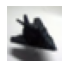

In [7]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

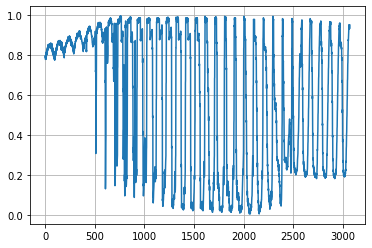

In [8]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
# size of image * 3 colors for RGB
plt.plot(np.arange(32*32*3), normal_data[0].ravel())
plt.show()

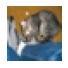

In [9]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

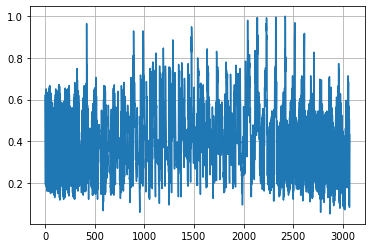

In [10]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(32*32*3), test_data[0].ravel())
plt.show()

In [41]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(64, (3, 3), padding='same'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same')])


    self.decoder = tf.keras.Sequential([
        Conv2D(16, (3, 3), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
        Conv2D(3, (3, 3), padding='same'),
        Conv2D(3, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('sigmoid')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()



In [42]:
autoencoder.compile(optimizer='adam', loss='mae')
#model = Model(input_img, decoded)
#model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

In [43]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
157/157 [==============================] - 4s 16ms/step - loss: 0.1244 - val_loss: 0.1420
Epoch 2/100
157/157 [==============================] - 2s 11ms/step - loss: 0.0940 - val_loss: 0.1176
Epoch 3/100
157/157 [==============================] - 2s 10ms/step - loss: 0.0868 - val_loss: 0.1071
Epoch 4/100
157/157 [==============================] - 2s 11ms/step - loss: 0.0821 - val_loss: 0.0976
Epoch 5/100
157/157 [==============================] - 2s 10ms/step - loss: 0.0796 - val_loss: 0.1065
Epoch 6/100
157/157 [==============================] - 2s 10ms/step - loss: 0.0769 - val_loss: 0.0965
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0754 - val_loss: 0.0835
Epoch 8/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0737 - val_loss: 0.0802
Epoch 9/100
157/157 [==============================] - 2s 11ms/step - loss: 0.0738 - val_loss: 0.0869
Epoch 10/100
157/157 [==============================] - 2s 11ms/step - loss: 0.071

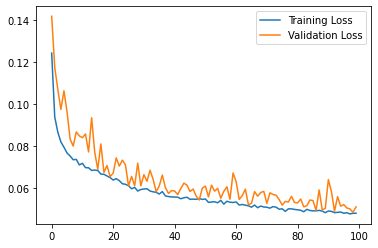

In [44]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

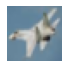

In [45]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

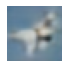

In [46]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

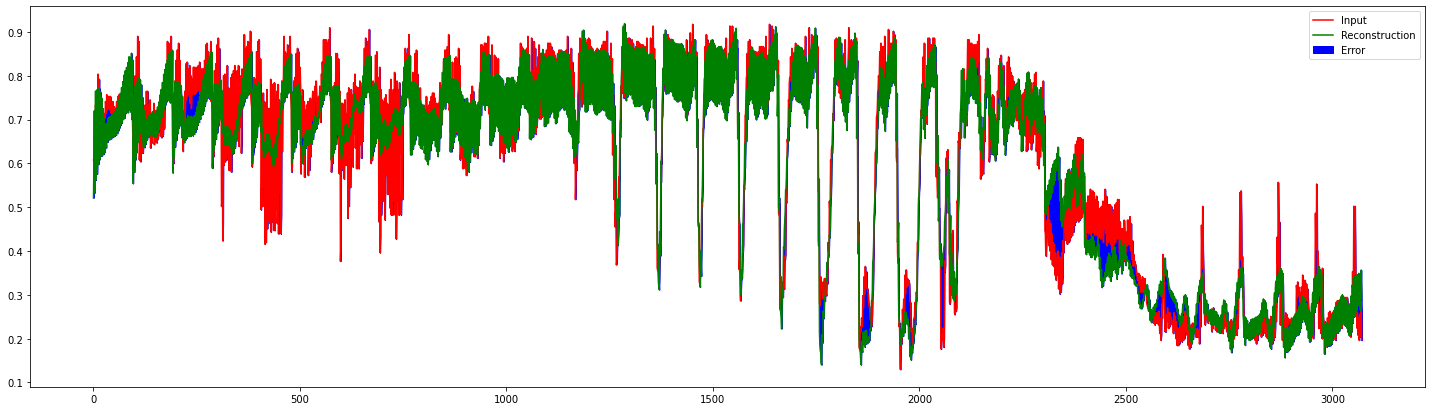

In [47]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

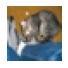

In [48]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

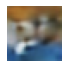

In [49]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

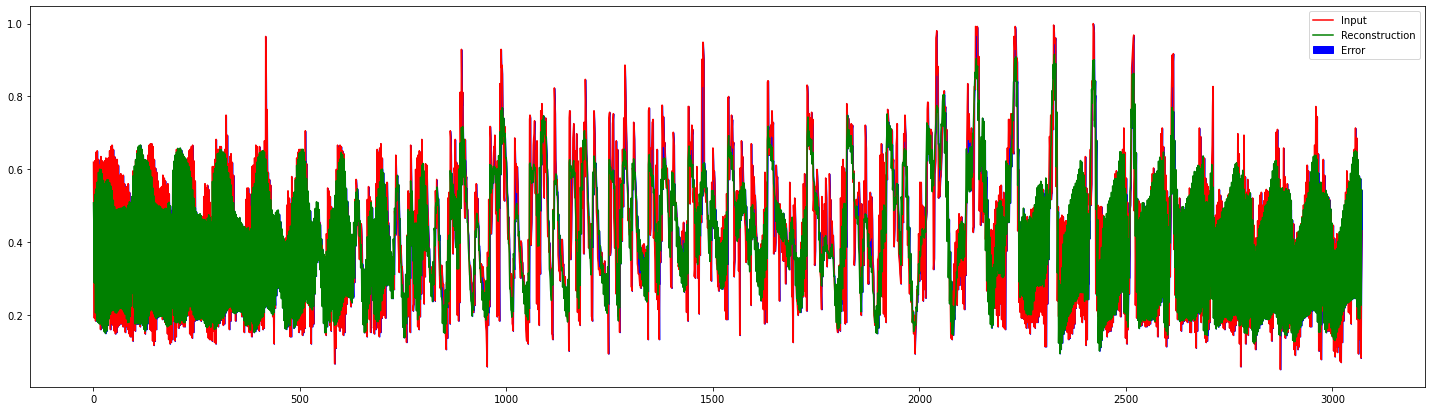

In [50]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

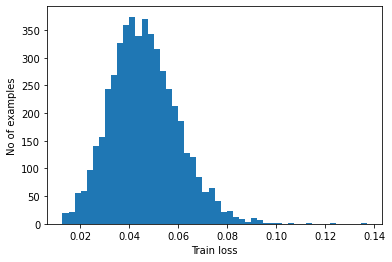

In [51]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), normal_data.reshape(-1, 32*32*3))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [52]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.046226855
Std:  0.013856094


In [53]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.0808670911937952


**Distribution of the reconstruction losses of the abnormal test data**

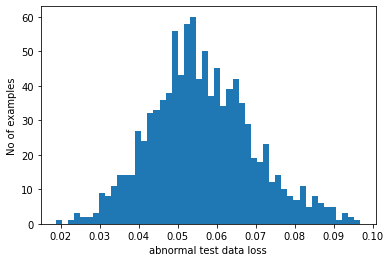

In [54]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), abnormal_test_data.reshape(-1, 32*32*3))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("abnormal test data loss")
plt.ylabel("No of examples")
plt.show()

In [55]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [56]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.05629379, 0.013122909)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [57]:
threshold = threshold1

**Calculation of the confusion matrix**

In [58]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), data.reshape(-1, 32*32*3))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [59]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             62   1938
 label: F   [[48   952]    1000
        T    [14   986]]   1000
Accuracy = 0.517
Precision = 0.5087719298245614
Recall = 0.986


In [60]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 48 952]
 [ 14 986]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

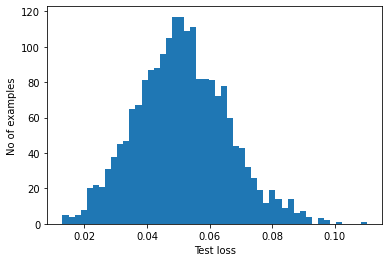

In [61]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,32*32*3), test_data.reshape(-1,32*32*3))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()